# Required libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from utils import *
from sklearn.model_selection import train_test_split

In [2]:
image_path_train = 'D:/TestData/train' # Replace with the path to the train images dir
image_path_test = 'D:/TestData/test' # Replace with the path to the test images dir

train_data = os.listdir(image_path_train)
test_data = os.listdir(image_path_test)

In [3]:
masks = pd.read_csv("D:/TestData/train_ship_segmentations_v2.csv") # Replace with the path to the masks file
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [4]:
masks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [5]:
test_masks = pd.read_csv("D:/TestData/sample_submission_v2.csv")
test_masks.head()

,ImageId,EncodedPixels
0,00002bd58.jpg,1 2
1,00015efb6.jpg,1 2
2,00023d5fc.jpg,1 2
3,000367c13.jpg,1 2
4,0008ca6e9.jpg,1 2


In [6]:
masks.ImageId.value_counts()

e6fd0c12e.jpg    15
2053a78bd.jpg    15
d3c47b3d3.jpg    15
4de149bd9.jpg    15
c8e722430.jpg    15
                 ..
591ab2331.jpg     1
591af2fb2.jpg     1
591afc23d.jpg     1
591b2dd30.jpg     1
ffffe97f3.jpg     1
Name: ImageId, Length: 192556, dtype: int64

In [7]:
masks['EncodedPixels'].isna().sum()

150000

As we can see, there are some images in the train dataset that have more than one ship on them, as well as images without any ships.

In [8]:
df = masks.groupby('ImageId').agg({'EncodedPixels': 'count'})
df = df.rename(columns={'EncodedPixels' : 'ships'})
df['has_ship'] = df['ships'].map(lambda x: 1 if x > 0 else 0)
df.head()

,ships,has_ship
ImageId,,
00003e153.jpg,0,0
0001124c7.jpg,0,0
000155de5.jpg,1,1
000194a2d.jpg,5,1
0001b1832.jpg,0,0


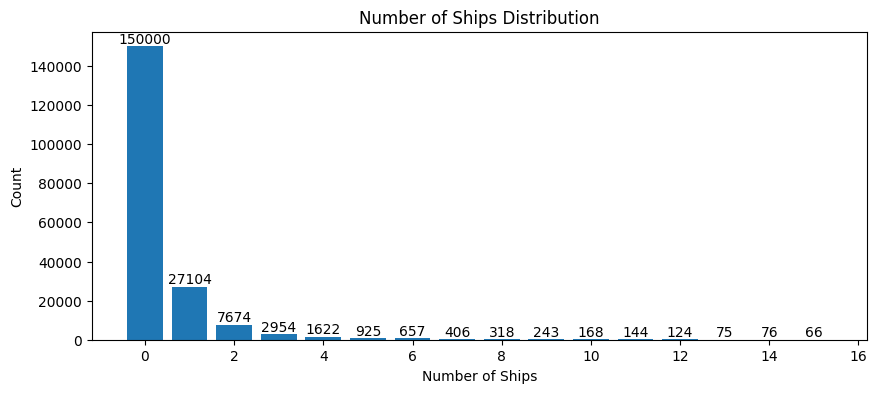

In [9]:
plt.figure(figsize=(10, 4))
plt.title('Number of Ships Distribution')
plt.xlabel('Number of Ships')
plt.ylabel('Count')

# Count the number of ships
ships_count = df.ships.value_counts().sort_index()

# Create bar chart
bars = plt.bar(ships_count.index, ships_count.values)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.show()


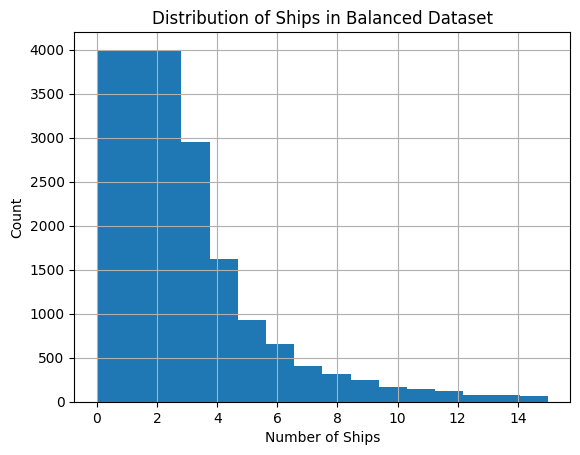

19778 masks


In [10]:
SAMPLES_PER_GROUP = 4000

# Balance the dataset
balanced_train_df = df.groupby('ships').apply(
    lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x
)

# Plot histogram
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
plt.title('Distribution of Ships in Balanced Dataset')
plt.xlabel('Number of Ships')
plt.ylabel('Count')
plt.show()

# Print number of samples
print(balanced_train_df.shape[0], 'masks')

In [25]:
# saving balanced df
balanced_train_df.to_csv("balanced_data.csv")

### Creating training dataset

In [12]:
# train/val split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.05, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids, right_on="ImageId", left_on="ImageId")
valid_df = pd.merge(masks, valid_ids, right_on="ImageId", left_on="ImageId")
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

52507 training masks
2764 validation masks


#### Masks decoding and creating image-mask pairs

In [14]:
train_gen = make_image_gen(train_df, image_path_train)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (64, 256, 256, 3) 0.0 1.0
y (64, 256, 256, 1) 0.0 1.0


In [15]:
valid_gen = make_image_gen(valid_df, image_path_train)
valid_x, valid_y = next(valid_gen)
print(valid_x.shape, valid_y.shape)

(64, 256, 256, 3) (64, 256, 256, 1)


In [16]:
cur_gen = create_aug_gen(train_gen)
aug_x, aug_y = next(cur_gen)
print('x', aug_x.shape, aug_x.dtype, aug_x.min(), aug_x.max())
print('y', aug_y.shape, aug_y.dtype, aug_y.min(), aug_y.max())

x (64, 256, 256, 3) float32 0.0 1.0
y (64, 256, 256, 1) float32 0.0 1.0


#### Visualization 

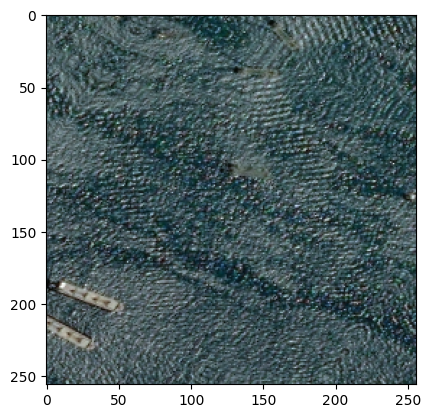

In [23]:
plt.imshow(aug_x[0])

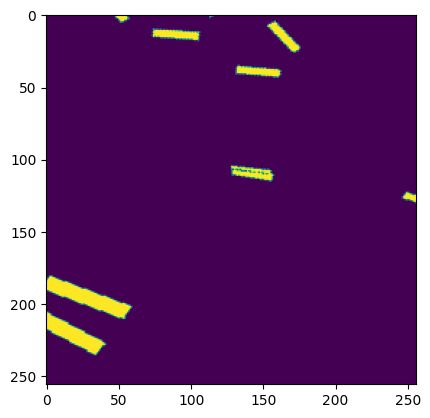

In [24]:
plt.imshow(aug_y[0])